Pour démarer la présentation : `jupyter nbconvert --config=Configuration.py Presentation.ipynb`

In [1]:
from sklearn import datasets, metrics, svm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')


# Validation croisée ✅

Présenté par Alix ANNERAUD et Hugo TONDENIER.

# 1. Principe 🔍

Qu'est-ce que la validation croisée et pourquoi est-elle utile ?

## 📖 Définition

- *🤖 : "La vérification croisée, aussi connue sous le nom de validation croisée, est une technique utilisée en machine learning pour évaluer la performance d'un modèle. L'objectif principal est de vérifier comment les résultats d'un modèle généré à partir d'un jeu de données donné vont généraliser sur un jeu de données indépendant. [...]"*

## 🏃 Entraînement d'un modèle

<img style="height: 500px;display: block;margin-left: auto;margin-right: auto;" src="Model_training.svg" alt="Model_training.svg" />

### 👶 Approche naïve

```mermaid
sankey-beta

%% source,target,value
Donnees,Entrainement,90.0
Donnees,Validation,10.0
```

- ✅ Simple.
- ❌ Biaisé.
- ❌ Pas toutes les données sont utilisées pour l'entraînement.

## ✅ Validation croisée
 
- *🤖 : "* ***Processus de Validation Croisée :***
  - ***Division des Données :*** *Le jeu de données initial est divisé en plusieurs sous-ensembles ou "folds". Une division courante est la validation croisée k-fold, où les données sont divisées en k sous-ensembles.*
  - ***Entraînement et Validation :*** *Pour chaque itération, un des k sous-ensembles est utilisé comme jeu de validation, et les k-1 autres sous-ensembles sont utilisés comme jeu d'entraînement. Ce processus est répété k fois, chaque sous-ensemble servant exactement une fois de jeu de validation.*
  - ***Évaluation :*** *À chaque itération, le modèle est évalué sur le jeu de validation et les performances (par exemple, précision, rappel, F1-score) sont enregistrées.*
  - **Agrégation des Résultats :** *Après k itérations, les résultats des k évaluations sont agrégés pour donner une estimation globale de la performance du modèle. Cela peut être fait en calculant la moyenne des performances des k itérations."*


## ✅ Validation croisée
 
- *🤖 : "* ***Avantages de la Validation Croisée :***
  - ***Réduction de l'Overfitting :*** *En utilisant différents sous-ensembles pour l'entraînement et la validation, la validation croisée aide à réduire le risque de surapprentissage (overfitting) sur un jeu de données spécifique.*
  - ***Utilisation Optimale des Données :*** *Toutes les données sont utilisées à la fois pour l'entraînement et pour la validation, ce qui est particulièrement avantageux lorsque le jeu de données est petit."*

## ✅ Validation croisée
 
- *🤖 : "* ***Types de Validation Croisée :***
  - ***k-fold Cross-Validation :*** *Le jeu de données est divisé en k sous-ensembles de taille égale. C'est la méthode la plus couramment utilisée.*
  - ***Leave-One-Out Cross-Validation (LOOCV) :*** *Une forme extrême de k-fold où k est égal au nombre de données dans le jeu de données (chaque donnée est utilisée une fois pour la validation, et toutes les autres pour l'entraînement).*
  - ***Stratified k-fold Cross-Validation :*** *Une version de la validation croisée k-fold où chaque fold contient environ la même proportion des différentes classes de la variable cible, ce qui est particulièrement utile pour les jeux de données déséquilibrés.*
  - ***Repeated k-fold Cross-Validation :*** *Une variation où la validation croisée k-fold est répétée plusieurs fois, avec des divisions différentes à chaque répétition, et les résultats sont moyennés."*

### 🔢 Validation croisée à $k$ blocs (k-fold)

<img style="height: 400px;display: block;margin-left: auto;margin-right: auto;" src="K_fold.svg" alt="Model_training.svg" />

- ✅ Production de $k$ modèles.
- ✅ Utilisation de toutes les données.
- ✅ Plus robuste.
- ⚠️ Certains plis peuvent être biaisés.
- ❌ Augmentation du temps de calcul.

### 🔀 Validation croisée par séparation aléatoire (shuffle-split)

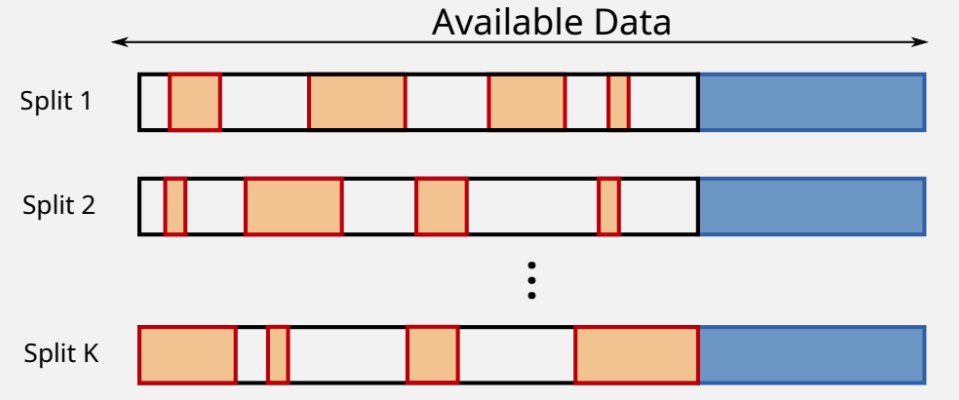

- ✅ Production de K modèles.
- ✅ Evite le biais des plis.
- ⚠️ Certaines données peuvent être utilisées plusieurs fois / pas du tout.
- ❌ Augmentation du temps de calcul


## ☢️ Sur-ajustement

In [2]:
# Génération de données synthétiques
np.random.seed(0)
X = np.sort(np.random.rand(20) * 10)
y = np.sin(X) + np.random.randn(20) * 0.5

def regression_polynomiale(X_prediction, degre):
    # Création du modèle
    model = make_pipeline(PolynomialFeatures(degre), LinearRegression())
    model.fit(X[:, np.newaxis], y)
    return model.predict(X_prediction[:, np.newaxis])

degrees = [1, 5, 10]

X_plot = np.linspace(0, 10, 100)

def illustration_sur_ajustement():
    plt.scatter(X, y, color='red', label='Données')
    for degree in degrees:
        plt.plot(X_plot, regression_polynomiale(X_plot, degree), label=f'Degré {degree}')
    plt.title('Régressions polynomiales de différents degrés')
    plt.legend()

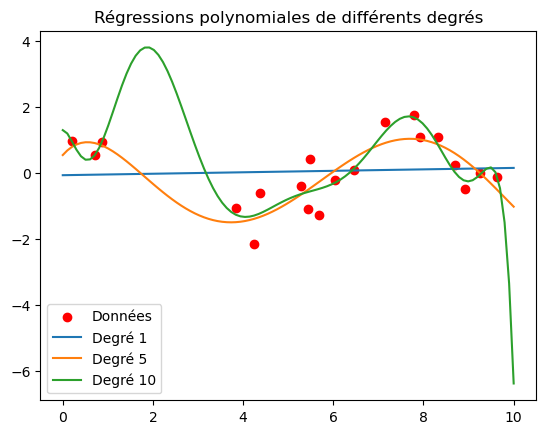

In [3]:
illustration_sur_ajustement()

## 🔭 Repérer le sur-ajustement

In [4]:
def illustration_reperage_sur_ajustement():
    # Simuler des pertes d'entraînement et de validation
    epochs = np.arange(1, 21)
    training_loss = np.exp(-epochs / 10) + 0.02 * np.random.randn(20)
    validation_loss = np.exp(-epochs / 10) + 0.05 * np.random.randn(20) + 0.2

    # Introduire le sur-ajustement artificiellement
    validation_loss[10:] += 0.1 * (epochs[10:] - 10)
    
    plt.plot(epochs, training_loss, 'b-', label='Perte d\'entraînement')
    plt.plot(epochs, validation_loss, 'r-', label='Perte de validation')
    plt.axvline(x=10, color='gray', linestyle='--', label='Début du sur-ajustement')

    plt.title('Erreur en fonction du nombre d\'itérations')
    plt.xlabel('Itérations')
    plt.ylabel('Erreur')
    plt.legend()
    plt.show()


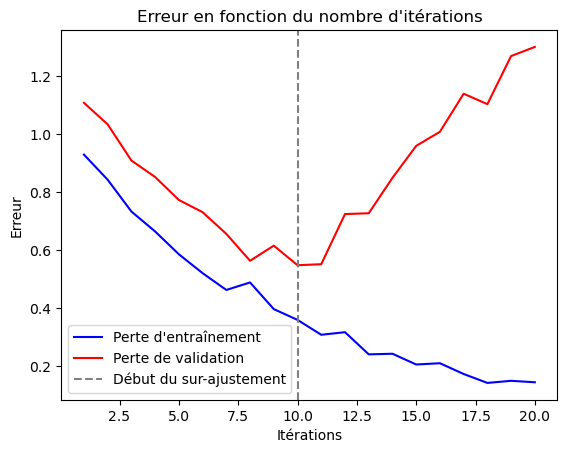

In [5]:
illustration_reperage_sur_ajustement()

# 2. Exemple 👀

Illustration de la validation croisée sur un jeu de données simple.

## 📊 Jeu de données

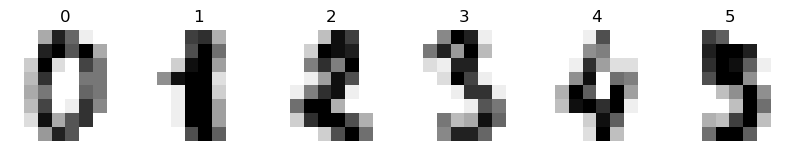

In [6]:
chiffres = datasets.load_digits()   # Importation du jeu de données

# Affichage des 6 premières images
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 5))
for ax, image, label in zip(axes, chiffres.images, chiffres.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title("%i" % label)

# "Aplatissement" des images (2D) en vecteurs de caractéristiques (1D)
n_samples = len(chiffres.images)
data = chiffres.images.reshape((n_samples, -1))

## ➗ Division du jeu de données

In [7]:
X_entrainement, X_test, y_entrainement, y_test =\
    train_test_split(data, chiffres.target, test_size=0.3, shuffle=False)

## 🧠 Modèle

In [8]:
def validation_croisee_regression_logistique(X, max_iter):
    # Création et entraînement du modèle
    regression = LogisticRegression(max_iter=int(max_iter))
    regression.fit(X_entrainement, y_entrainement)

    # Validation croisée
    precisions = cross_val_score(regression, data, chiffres.target,\
         cv=5, scoring='accuracy')

    return precisions

## 🚔 Intervention de la validation croisée

In [9]:
def illustration_intervention_validation_croisee():
    precisions = {}
    maximum_iterations = np.logspace(1, 3, 10)

    for max_iter in maximum_iterations:
        max_iter = int(max_iter)       
        precisions[str(max_iter)] = validation_croisee_regression_logistique(data, max_iter)

    _, axes = plt.subplots()
    axes.boxplot(precisions.values())
    axes.set_xticklabels(precisions.keys())
    axes.set_xlabel('`max_iter`')
    axes.set_ylabel('Précision')

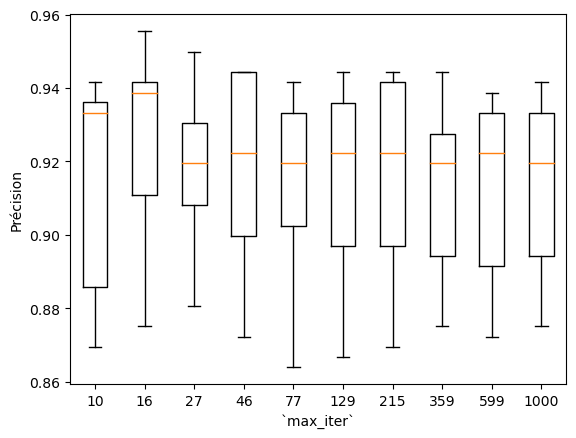

In [10]:
illustration_intervention_validation_croisee()

## 🤖 Optimisation automatique

In [11]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Plus C est élevé, plus la régularisation est faible
    'gamma': [0.001, 0.01, 0.1, 1],  # Plus gamma est élevé, plus le modèle est complexe
    'kernel': ['rbf', 'poly', 'sigmoid']  # Types de noyaux à tester
}

# Création du modèle SVM avec GridSearchCV
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5,\
                            scoring='accuracy', verbose=1)
grid_search.fit(X_entrainement, y_entrainement);

# Affichage des meilleurs paramètres
print("Meilleurs paramètres trouvées : ", grid_search.best_params_)
best_svm = grid_search.best_estimator_

# Prédiction et évaluation sur l'ensemble de test
predictions = best_svm.predict(X_test)
print("Précision: {:.2f}%".format(accuracy_score(y_test, predictions) * 100))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Meilleurs paramètres trouvées :  {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Précision: 97.04%


# 📚 Bibliographie

- "The Elements of Statistical Learning", livre de Jerome H. Friedman, Robert Tibshirani et Trevor Hastie.
- Cours de I4 : "Découverte de l'intelligence artificielle" de Benoït GAUZÈRE et Nicolas DELESTRE.
- Documentation de SciKit Learn : "Recognizing hand-written digits" [https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html).


# Nous vous remercions pour votre attention 🙏